### 安装并导入scipy和matplotlib, 输出路径，scipy.fft和numpy.fft相比，更推荐用前者。

In [103]:
import scipy, matplotlib
print(scipy.__file__)
print(matplotlib.__file__)

/Users/ss/anaconda3/lib/python3.11/site-packages/scipy/__init__.py
/Users/ss/anaconda3/lib/python3.11/site-packages/matplotlib/__init__.py


## 信号里的噪声去除问题
### sample_rate为信号频率，duration为持续时间, endpoint=False很重要因为假设信号是周期的
### audio CDs have a sampling rate of 44100 samples/second

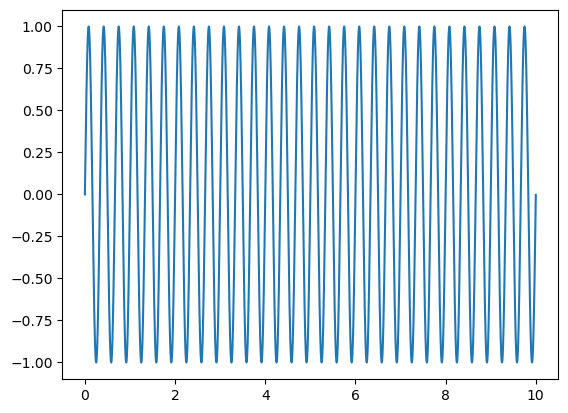

[0.0000e+00 1.0000e-04 2.0000e-04 ... 9.9997e+00 9.9998e+00 9.9999e+00] [ 0.          0.00188495  0.0037699  ... -0.00565484 -0.0037699
 -0.00188495]


In [107]:
import numpy as np
from matplotlib import pyplot as plt

SAMPLE_RATE = 10000  # Hertz
DURATION = 10  # Seconds

def generate_sine_wave(freq, sample_rate, duration):
    x = np.linspace(0, duration, sample_rate * duration, endpoint=False)
    frequencies = x * freq
    # 2pi because np.sin takes radians
    y = np.sin((2 * np.pi) * frequencies)
    return x, y

# Generate a 2 hertz sine wave that lasts for 5 seconds
x, y = generate_sine_wave(3, SAMPLE_RATE, DURATION)
plt.plot(x, y)
plt.show()
print(x,y)

### 生成噪声，混入原声中，输出声音文件
### generate_sine_wave的输出为x, y，这里不需要x，所以用‘_‘去掉
### 转换成int16格式
### 思考：为什么我们能听到声音的和弦，但是看不到”光学的和弦”

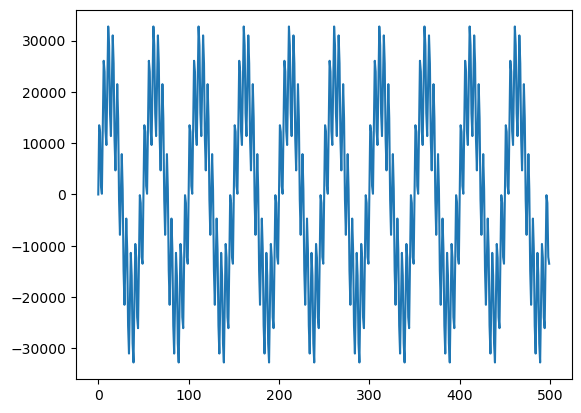

In [108]:
_, nice_tone = generate_sine_wave(200, SAMPLE_RATE, DURATION)    #100 
_, noise_tone = generate_sine_wave(2000, SAMPLE_RATE, DURATION)  #2000
noise_tone = noise_tone * 0.5

mixed_tone = nice_tone + noise_tone

normalized_tone = np.int16((mixed_tone / mixed_tone.max()) * 32767)
plt.plot(normalized_tone[:500])
plt.show()

from scipy.io.wavfile import write
# Remember SAMPLE_RATE = 44100 Hz is our playback rate
write("mysinewave.wav", SAMPLE_RATE, normalized_tone)


### 调用傅立叶程序包，对信号进行傅立叶变换
### fft()给出变换的结果
### fftwfreq()给出每个频率bin的值
### yf为虚数，np.abs()计算其强度
### 思考N是否可以换成其他数->  Nyquist=0.5 * sampling rate，采样率至少要2倍于最高频信号才能“找到”噪声

In [148]:
from scipy.fft import fft, fftfreq

# Number of samples in normalized_tone
N = SAMPLE_RATE * DURATION

yf = fft(normalized_tone)
xf = fftfreq(N), 1 / SAMPLE_RATE)

plt.plot(xf*10, np.abs(yf))
plt.show()
max(np.abs(yf))
max(xf)

ValueError: n should be an integer

### 由此可见，fft()的输出结果与y轴对称，此对称性是由于输入量为实数造成的。
### 利用快速傅立叶变换仅需计算一半，替换fft -> rfft即可

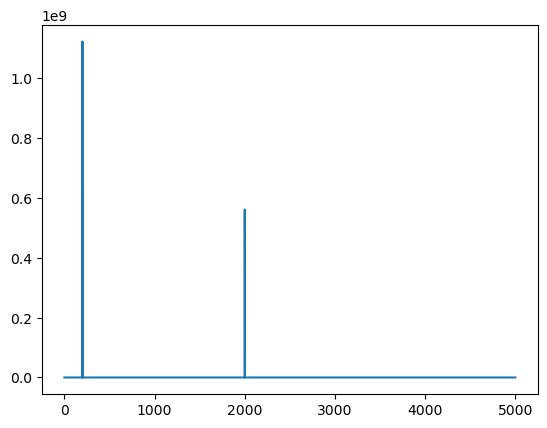

In [134]:
from scipy.fft import rfft, rfftfreq
yf = rfft(normalized_tone)
xf = rfftfreq(N, 1 / SAMPLE_RATE)

plt.plot(xf, np.abs(yf))
plt.show()


### 在频率空间过滤噪声

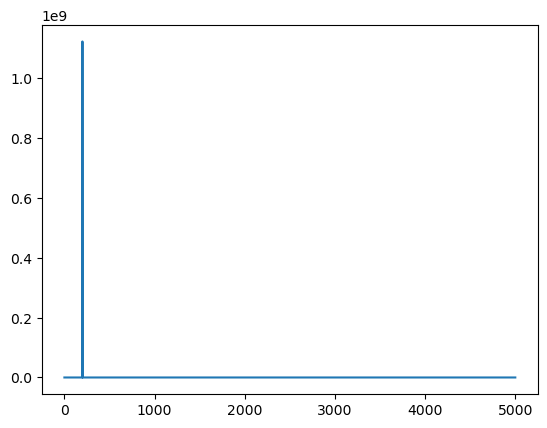

In [137]:
# The maximum frequency is half the sample rate
points_per_freq = len(xf) / (SAMPLE_RATE / 2)

# Our target frequency is 4000 Hz
target_idx = int(points_per_freq * 2000)

yf[target_idx - 1 : target_idx + 2] = 0

plt.plot(xf, np.abs(yf))
plt.show()

### 逆傅立叶变换恢复信号，输出文件

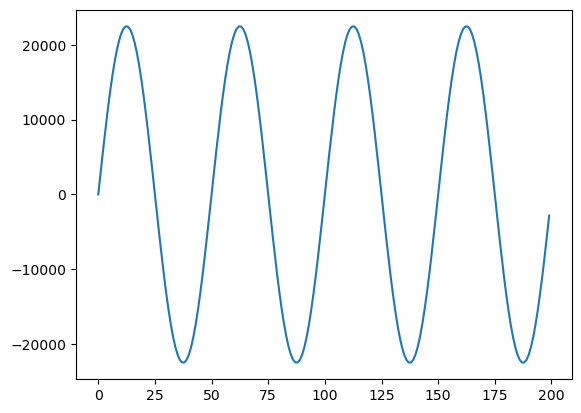

In [138]:
from scipy.fft import irfft

new_sig = irfft(yf)

plt.plot(new_sig[:200])
plt.show()

norm_new_sig = np.int16(new_sig * (32767 / new_sig.max()))
write("clean.wav", SAMPLE_RATE, norm_new_sig)

## 现实情况只会更加复杂，如果需要请查阅scipy.signal程序包